In [1]:
import json
import io
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

from rtree import index

In [2]:
def parse_output(fileid):
    folder = 'saved'
    stats_filename = f'{folder}/stats-{fileid}.csv'
    df = pd.read_csv(stats_filename, header=2)
    
    # Augmented fields
    df['node_id'] = df['current_node_lat'].astype(str) + df['current_node_lon'].astype(str)
    df['parent_node_id'] = df['parent_node_lat'].astype(str) + df['parent_node_lon'].astype(str)
    
    meta_data = {}
    with open(stats_filename) as file:
        for key in ['start_node', 'target_node']:
            meta_data[key] = [
                float(c) 
                for c in file.readline().split(':')[1].strip().split(',')
            ]
            
    
    
    return df.iloc[1:-1], meta_data

In [3]:
def load_charging_stations(path):
    with open(path) as file:
        charging_stations = json.load(file)
    return charging_stations

def cs_rindex(charging_stations):
    rt_idx = index.Index()
    for i, data in enumerate(charging_stations):
        lon = data['lon']
        lat = data['lat']
        rt_idx.insert(i, (lon, lat, lon, lat))
    return rt_idx

In [4]:
charging_stations = load_charging_stations('charging_stations.json')
cs_rtree = cs_rindex(charging_stations)
def get_cs_bounding_box(lon_nw, lat_nw, lon_se, lat_se):
    return [
        charging_stations[i] 
        for i in cs_rtree.intersection((lon_nw, lat_se, lon_se, lat_nw))
    ]
    

In [5]:
slow, slow_meta = parse_output('325698766306460225-original')
fast, fast_meta = parse_output('325698766306460225')

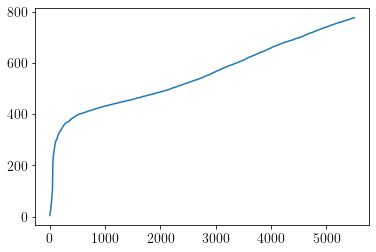

In [6]:
slow['t_min'].plot()

In [7]:
counts = slow['node_id'].value_counts()

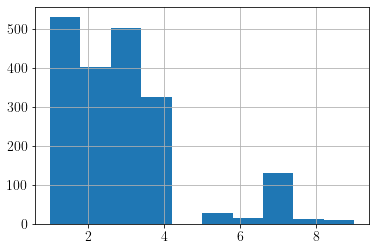

In [8]:
counts.hist()

In [9]:
edge_counts = slow['edge'].value_counts()

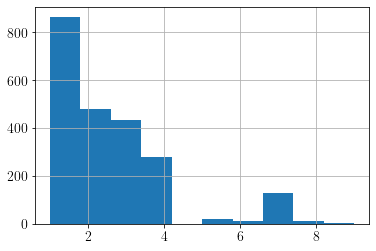

In [10]:
edge_counts.hist()

In [11]:
fast['set_labels_cur_node'].plot()

In [12]:
fast.head()

edge      t_min       soc_min  current_node_lat  \
1  325698766-3669616333   4.769540  39980.126918         49.259970   
2   325698766-321243195   9.815424  39959.102402         49.259839   
3  3669616333-302059609  11.433179  39952.361756         49.259755   
4   321243195-325698770  11.492641  39952.113997         49.259839   
5   325698770-325698780  12.959570  39946.001791         49.259949   

   current_node_lon  parent_node_lat  parent_node_lon  set_labels_cur_node  \
1         12.277774        49.260093        12.277260                    1   
2         12.276206        49.260093        12.277260                    1   
3         12.278464        49.259970        12.277774                    1   
4         12.276014        49.259839        12.276206                    1   
5         12.276022        49.259839        12.276014                    1   

   set_labels  unset_labels  labels_created  prio_queue  \
1           2             2               4           3   
2           3             3               6           4   
3           4             4               8           5   
4           5             5              10           6   
5           6             6              12           7   

                        node_id                        parent_node_id  
1            49.2599712.2777739  49.26009349999999612.277260400000001  
2  49.259839212.276206199999999  49.26009349999999612.277260400000001  
3          49.259754712.2784638                    49.2599712.2777739  
4          49.259839212.2760136          49.259839212.276206199999999  
5            49.25994912.276022                  49.259839212.2760136

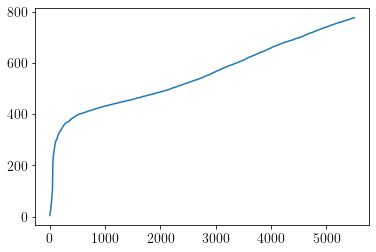

In [13]:
fast['t_min'].plot()

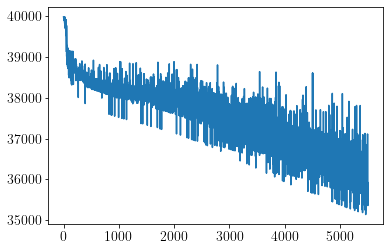

In [14]:
fast['soc_min'].plot()

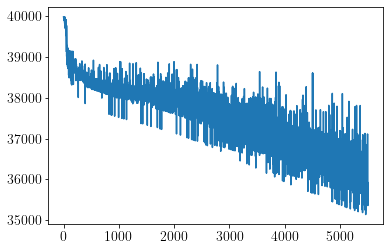

In [15]:
slow['soc_min'].plot()

In [16]:
def plot_path(df, meta_data, min_visited=0):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    def get_map(lat_nw, lon_nw, lat_se, lon_se):
        token = 'UwGAC90K9vNAVhARtf2h4XDuJ5fi1Scw'
        url = f'https://www.mapquestapi.com/staticmap/v5/map?key={token}&boundingBox={lat_nw},{lon_nw},{lat_se},{lon_se}'
        print(url)
        return urllib.request.urlopen(url).read(), 'jpeg'
    
    def get_map_mapbox(lat_nw, lon_nw, lat_se, lon_se):
        lat = lat_se + (lat_nw - lat_se) / 2
        lon = lon_nw + (lon_se - lon_nw) / 2
        zoom = 10
        token = 'pk.eyJ1IjoibWFxbml1cyIsImEiOiJjazlkMW55ZGQwOG5nM2xubXQ5bnJ3OHZuIn0.V-aPVPchCpsK8LfT9OrLVg'
        url = f'https://api.mapbox.com/styles/v1/mapbox/streets-v11/static/{lon},{lat},{zoom},0/200x200?access_token={token}'
        print(url)
        return urllib.request.urlopen(url).read(), 'png'
    
    paths = df[[
        'edge', 
        'current_node_lat', 
        'current_node_lon', 
        'parent_node_lat', 
        'parent_node_lon']].groupby('edge').mean()
    paths['count'] = df['edge'].value_counts()
    
    cNorm = colors.Normalize(vmin=0, vmax=max(paths['count'].values))
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    lon_start, lat_start = meta_data['start_node']
    lon_target, lat_target = meta_data['target_node']
    ax.scatter(
        [lon_start], [lat_start], 
        s = [20*4*4],
        color='g',
        marker=7, 
        label='Start')
    ax.scatter([lon_target], [lat_target], 
               s = [20*4*4],
               color='r', 
               marker=7, 
               label='Ziel')
    
    for _, row in paths[paths['count'] > min_visited].iterrows():
        x = [row['current_node_lon'], row['parent_node_lon']]
        y = [row['current_node_lat'], row['parent_node_lat']]
        ax.plot(x, y,
                linewidth=1.,
                zorder=0, 
                color=scalarMap.to_rgba(row['count']))
    
    ax.set_aspect('equal', adjustable='box')
    #ax.set_xlim(12.225, 12.350)
    #ax.set_ylim(49.20, 49.30)
    lon_nw, lon_se = ax.get_xlim()
    lat_se, lat_nw = ax.get_ylim()
    
    _charging_stations = get_cs_bounding_box(lon_nw, lat_nw, lon_se, lat_se)
    ax.scatter(
        [cs['lon'] for cs in _charging_stations],
        [cs['lat'] for cs in _charging_stations],
        s = len(_charging_stations) * [20*4*6],
        color='orange', 
        edgecolors='black',
        marker='.',
        label='Ladesäule'
    )
    ax.legend(loc='lower left', markerscale=0.8)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(scalarMap, cax=cax, label='$n$ mal besucht')
    ax.set_xlabel('Längengrad')
    ax.set_ylabel('Breitengrad')
    plt.savefig('../evaluation/img/edges.pdf', bbox='tight')


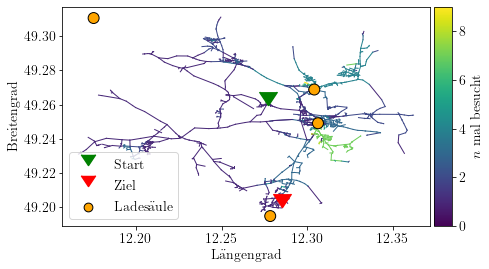

In [17]:
plot_path(fast, fast_meta)